In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 340

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

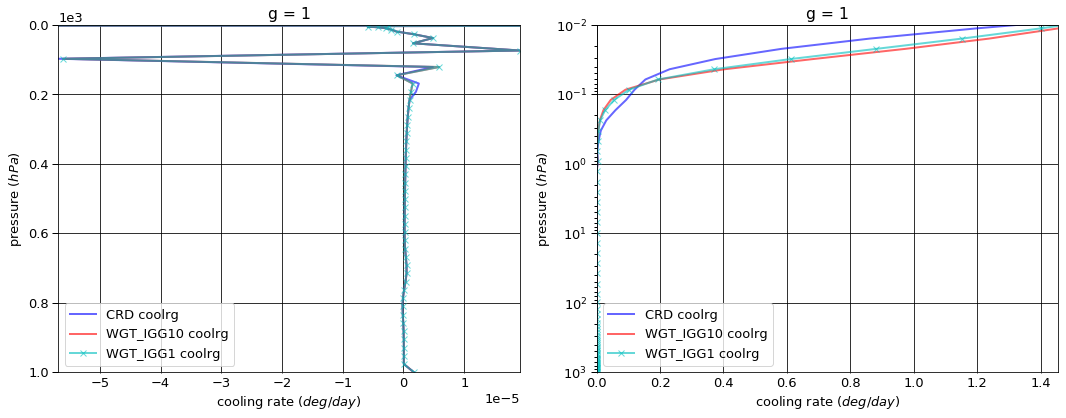

# Figure: cooling rate g-group 2

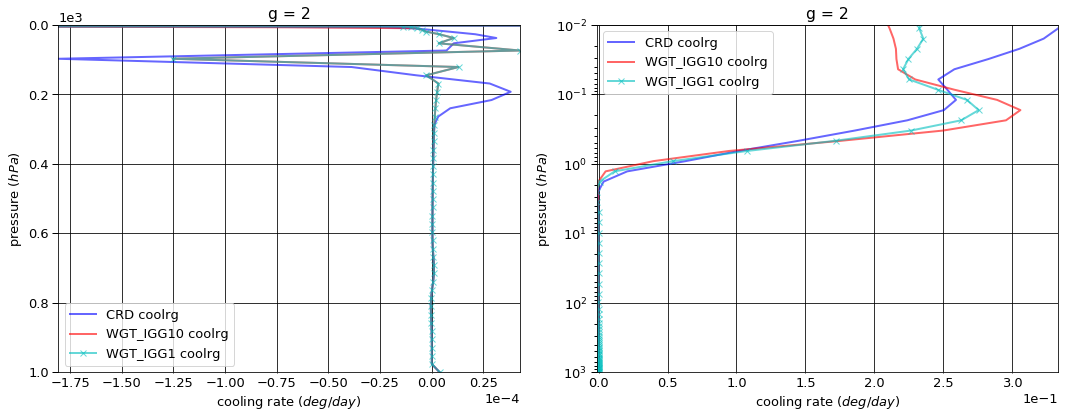

# Figure: cooling rate g-group 3

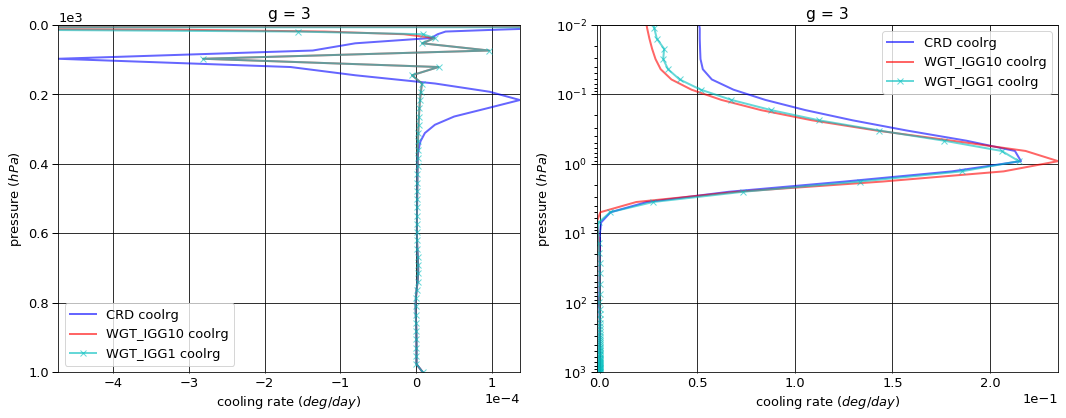

# Figure: cooling rate g-group 4

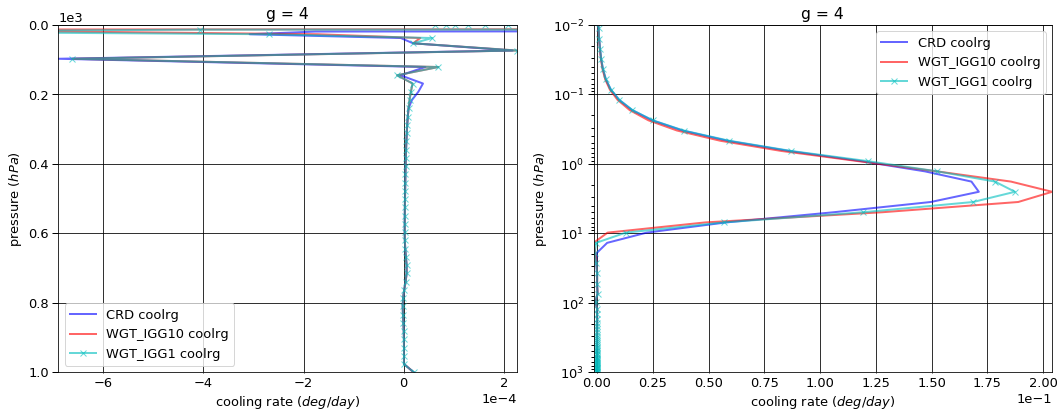

# Figure: cooling rate g-group 5

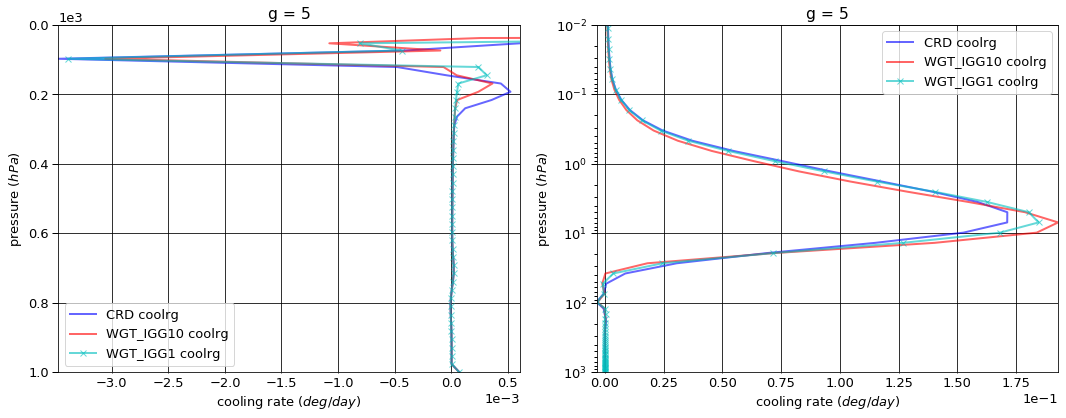

# Figure: cooling rate g-group 6

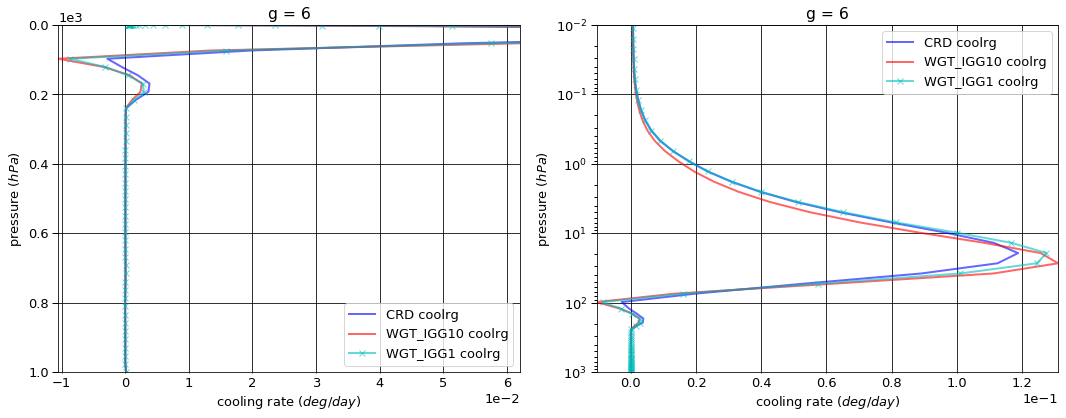

# Figure: cooling rate g-group 7

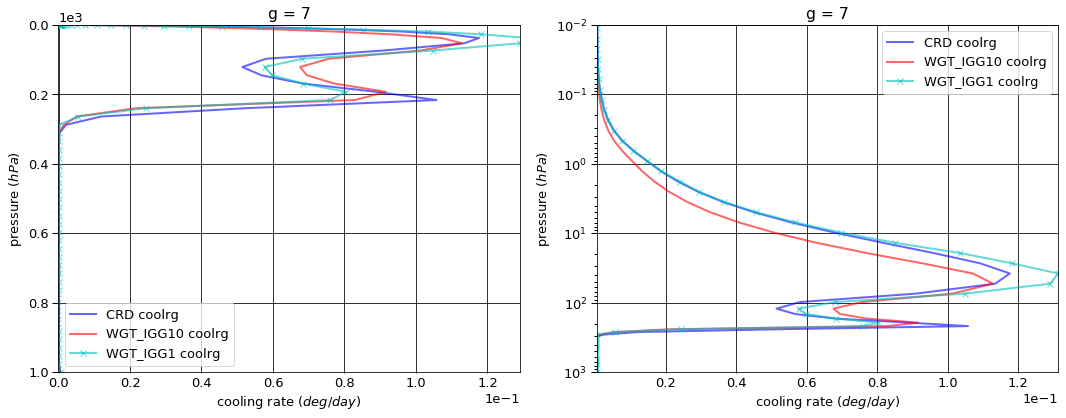

# Figure: cooling rate g-group 8

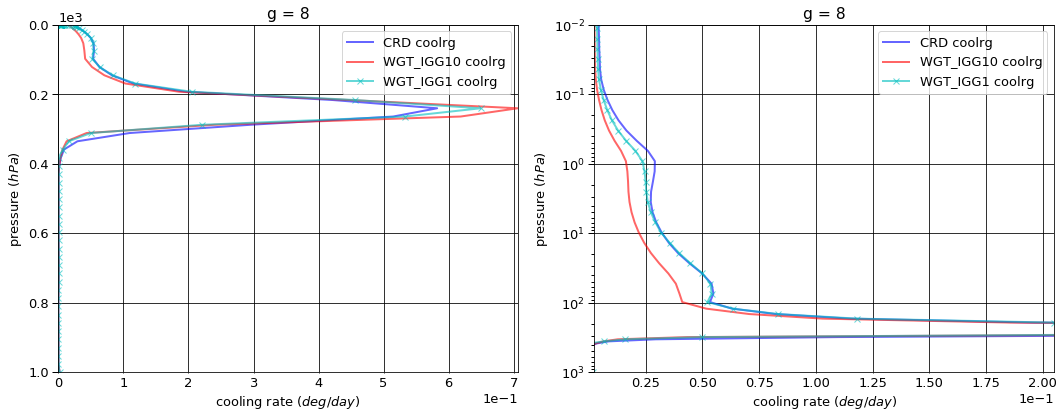

# Figure: cooling rate g-group 9

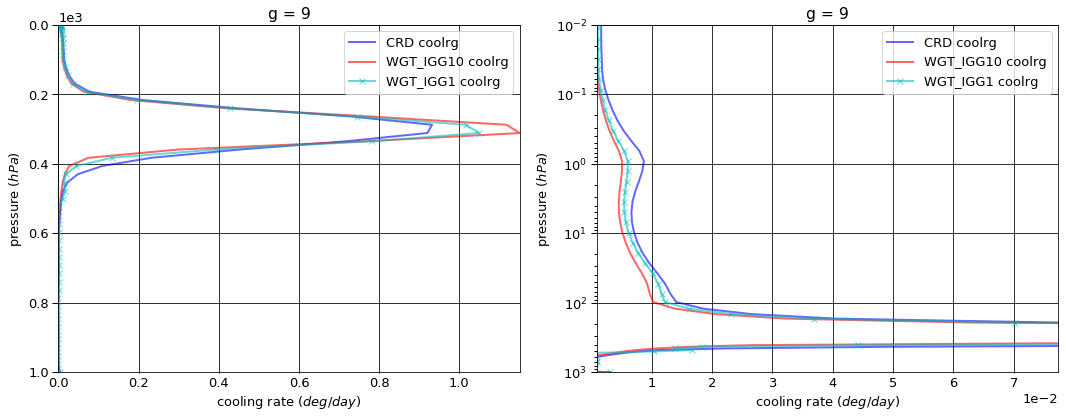

# Figure: cooling rate g-group 10

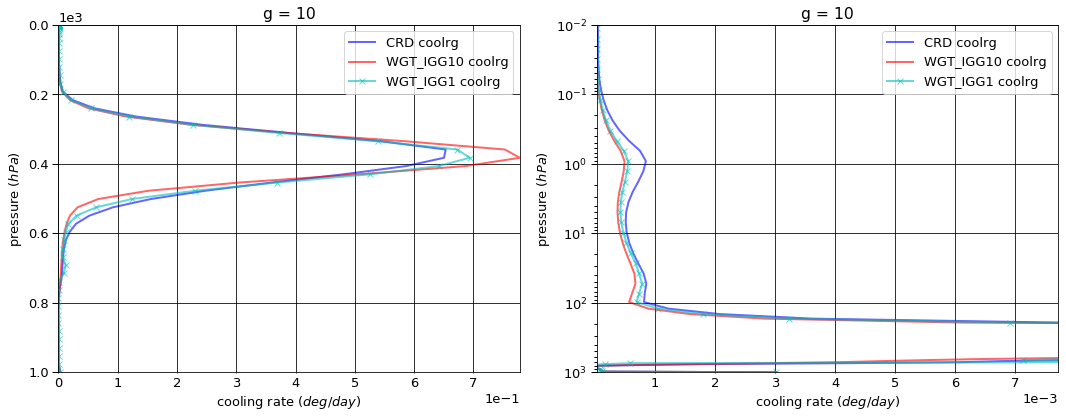

# Figure: cooling rate g-group total

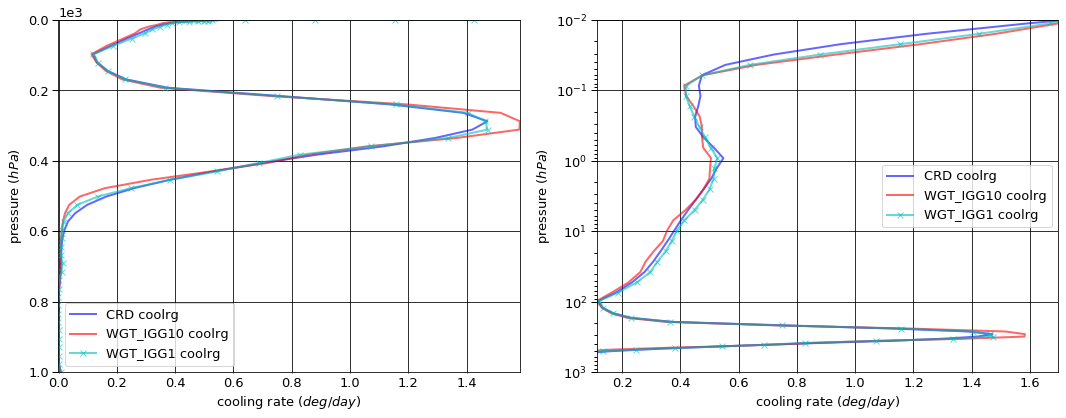

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007391   0.000000  -0.007391
   1013.0   76     -0.012879   0.012875  -0.000005
2  0.0      1      -0.019351   0.000000  -0.019351
   1013.0   76     -0.028285   0.028274  -0.000011
3  0.0      1      -0.050426   0.000000  -0.050426
   1013.0   76     -0.064681   0.064656  -0.000024
4  0.0      1      -0.113280   0.000000  -0.113280
   1013.0   76     -0.152841   0.152785  -0.000056
5  0.0      1      -0.351316   0.000000  -0.351316
   1013.0   76     -0.535164   0.534965  -0.000199
6  0.0      1      -0.686261   0.000000  -0.686261
   1013.0   76     -1.191323   1.190888  -0.000435
7  0.0      1      -2.373122   0.000000  -2.373122
   1013.0   76     -4.388461   4.386826  -0.001634
8  0.0      1      -7.472724   0.000000  -7.472724
   1013.0   76    -12.450828  12.446177  -0.004651
9  0.0      1     -14.300191   0.000000 -14.300191
   1013.0   76    -21.878796  21.870307  -0.008490
10 0.0      1     -13.496020   0.000000 -13.496020
   1013.0   76    -19.521876  19.513490  -0.008387


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007267   0.000000  -0.007267
   1013.0   76     -0.012879   0.012875  -0.000005
2  0.0      1      -0.019337   0.000000  -0.019337
   1013.0   76     -0.028285   0.028274  -0.000011
3  0.0      1      -0.051134   0.000000  -0.051134
   1013.0   76     -0.064681   0.064656  -0.000024
4  0.0      1      -0.114855   0.000000  -0.114855
   1013.0   76     -0.152841   0.152785  -0.000056
5  0.0      1      -0.354541   0.000000  -0.354541
   1013.0   76     -0.535164   0.534965  -0.000199
6  0.0      1      -0.692151   0.000000  -0.692151
   1013.0   76     -1.191323   1.190888  -0.000435
7  0.0      1      -2.318047   0.000000  -2.318047
   1013.0   76     -4.388461   4.386826  -0.001634
8  0.0      1      -7.484224   0.000000  -7.484224
   1013.0   76    -12.450828  12.446177  -0.004651
9  0.0      1     -14.207726   0.000000 -14.207726
   1013.0   76    -21.878796  21.870307  -0.008490
10 0.0      1     -13.398329   0.000000 -13.398329
   1013.0   76    -19.521876  19.513499  -0.008378


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007280   0.000000  -0.007280
   1013.0   76     -0.012879   0.012875  -0.000005
2  0.0      1      -0.019521   0.000000  -0.019521
   1013.0   76     -0.028285   0.028274  -0.000011
3  0.0      1      -0.050801   0.000000  -0.050801
   1013.0   76     -0.064681   0.064656  -0.000024
4  0.0      1      -0.114224   0.000000  -0.114224
   1013.0   76     -0.152841   0.152785  -0.000056
5  0.0      1      -0.353830   0.000000  -0.353830
   1013.0   76     -0.535164   0.534965  -0.000199
6  0.0      1      -0.693326   0.000000  -0.693326
   1013.0   76     -1.191323   1.190888  -0.000435
7  0.0      1      -2.329971   0.000000  -2.329971
   1013.0   76     -4.388461   4.386826  -0.001634
8  0.0      1      -7.408132   0.000000  -7.408132
   1013.0   76    -12.450828  12.446177  -0.004651
9  0.0      1     -14.225512   0.000000 -14.225512
   1013.0   76    -21.878796  21.870307  -0.008490
10 0.0      1     -13.472482   0.000000 -13.472482
   1013.0   76    -19.521876  19.513499  -0.008378


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1      1.240302e-04  0.000000  1.240302e-04
   1013.0   76     0.000000e+00  0.000000 -8.470329e-22
2  0.0      1      1.473700e-05  0.000000  1.473700e-05
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
3  0.0      1     -7.082020e-04  0.000000 -7.082020e-04
   1013.0   76     0.000000e+00  0.000000 -3.388132e-21
4  0.0      1     -1.575470e-03  0.000000 -1.575470e-03
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1     -3.225130e-03  0.000000 -3.225130e-03
   1013.0   76    -1.110223e-16  0.000000  0.000000e+00
6  0.0      1     -5.889930e-03  0.000000 -5.889930e-03
   1013.0   76     0.000000e+00  0.000000 -5.421011e-20
7  0.0      1      5.507560e-02  0.000000  5.507560e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1     -1.150040e-02  0.000000 -1.150040e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
9  0.0      1      9.246500e-02  0.000000  9.246500e-02
   1013.0   76    -3.552714e-15  0.000000  0.000000e+00
10 0.0      1      9.769100e-02  0.000000  9.769100e-02
   1013.0   76     3.552714e-15  0.000009  9.031300e-06


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1      1.108128e-04  0.000000  1.108128e-04
   1013.0   76     0.000000e+00  0.000000 -8.470329e-22
2  0.0      1     -1.694120e-04  0.000000 -1.694120e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
3  0.0      1     -3.756250e-04  0.000000 -3.756250e-04
   1013.0   76     0.000000e+00  0.000000 -3.388132e-21
4  0.0      1     -9.442300e-04  0.000000 -9.442300e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
5  0.0      1     -2.514180e-03  0.000000 -2.514180e-03
   1013.0   76    -1.110223e-16  0.000000  0.000000e+00
6  0.0      1     -7.064740e-03  0.000000 -7.064740e-03
   1013.0   76     0.000000e+00  0.000000 -5.421011e-20
7  0.0      1      4.315080e-02  0.000000  4.315080e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
8  0.0      1      6.459160e-02  0.000000  6.459160e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
9  0.0      1      7.467900e-02  0.000000  7.467900e-02
   1013.0   76    -3.552714e-15  0.000000  0.000000e+00
10 0.0      1      2.353800e-02  0.000000  2.353800e-02
   1013.0   76     3.552714e-15  0.000009  9.031300e-06

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer          
1  0.000312    1      3.956958
   1001.112500 75     0.000002
2  0.000312    1      0.322973
   1001.112500 75     0.000004
3  0.000312    1      0.043495
   1001.112500 75     0.000009
4  0.000312    1      0.000045
   1001.112500 75     0.000020
5  0.000312    1      0.000843
   1001.112500 75     0.000072
6  0.000312    1      0.000476
   1001.112500 75     0.000157
7  0.000312    1      0.000463
   1001.112500 75     0.000588
8  0.000312    1      0.003526
   1001.112500 75     0.001675
9  0.000312    1      0.001304
   1001.112500 75     0.003057
10 0.000312    1      0.000035
   1001.112500 75     0.003020


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      1.970568
   1001.112500 75     0.000002
2  0.000312    1      0.175822
   1001.112500 75     0.000004
3  0.000312    1      0.018441
   1001.112500 75     0.000009
4  0.000312    1      0.000059
   1001.112500 75     0.000020
5  0.000312    1      0.000671
   1001.112500 75     0.000072
6  0.000312    1      0.000422
   1001.112500 75     0.000157
7  0.000312    1      0.000297
   1001.112500 75     0.000588
8  0.000312    1      0.002010
   1001.112500 75     0.001675
9  0.000312    1      0.000701
   1001.112500 75     0.003057
10 0.000312    1      0.000019
   1001.112500 75     0.003015


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      2.417168
   1001.112500 75     0.000002
2  0.000312    1      0.206369
   1001.112500 75     0.000004
3  0.000312    1      0.021458
   1001.112500 75     0.000009
4  0.000312    1      0.000063
   1001.112500 75     0.000020
5  0.000312    1      0.000749
   1001.112500 75     0.000072
6  0.000312    1      0.000502
   1001.112500 75     0.000157
7  0.000312    1      0.000413
   1001.112500 75     0.000588
8  0.000312    1      0.002981
   1001.112500 75     0.001675
9  0.000312    1      0.000857
   1001.112500 75     0.003057
10 0.000312    1      0.000022
   1001.112500 75     0.003015


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.986390e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.471512e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -2.505373e-02
   1001.112500 75    -1.694066e-21
4  0.000312    1      1.366708e-05
   1001.112500 75     0.000000e+00
5  0.000312    1     -1.716197e-04
   1001.112500 75     0.000000e+00
6  0.000312    1     -5.354734e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -1.663563e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.515987e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -6.033541e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.624561e-05
   1001.112500 75    -4.194700e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.539790e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.166041e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -2.203686e-02
   1001.112500 75    -1.694066e-21
4  0.000312    1      1.800553e-05
   1001.112500 75     0.000000e+00
5  0.000312    1     -9.419621e-05
   1001.112500 75     0.000000e+00
6  0.000312    1      2.678715e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -5.051690e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -5.444457e-04
   1001.112500 75     0.000000e+00
9  0.000312    1     -4.466834e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -1.309357e-05
   1001.112500 75    -4.194700e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.870081,0.000000,-38.870081
1013.0,76,-60.225133,60.201242,-0.023892



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.647610,0.000000,-38.647610
1013.0,76,-60.225133,60.201251,-0.023883



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.675079,0.000000,-38.675079
1013.0,76,-60.225133,60.201251,-0.023883



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.224712e-01,0.000000,0.222471
1013.0,76,7.105427e-15,0.000009,0.000009



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.950020e-01,0.000000,0.195002
1013.0,76,7.105427e-15,0.000009,0.000009


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.330118
1001.112500,75,0.008603



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.169010
1001.112500,75,0.008598



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.650584
1001.112500,75,0.008598



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.161109
1001.112500,75,-0.000004



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.679535
1001.112500,75,-0.000004


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000250,0.000219
2,0.000485,0.000474
3,0.001324,0.001098
4,0.003015,0.002605
5,0.011074,0.009089
6,0.024324,0.020338
7,0.090544,0.074488
8,0.248324,0.211068
9,0.383882,0.366104


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.096164e-16
2,1.309690e-17
3,1.564810e-18
4,4.601703e-18
5,5.682550e-19
6,6.154553e-19
7,7.853808e-20
8,1.002222e-20
9,1.278933e-21


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.096164e-16,NaN,0.000250,0.000219,0.000250,0.000219,1.0
2,1.309690e-17,0.119479,0.000485,0.000474,0.000735,0.000692,1.0
3,1.564810e-18,0.119479,0.001324,0.001098,0.002059,0.001791,1.0
4,4.601703e-18,2.940742,0.003015,0.002605,0.005074,0.004395,30.0
5,5.682550e-19,0.123488,0.011074,0.009089,0.016147,0.013484,30.0
6,6.154553e-19,1.083062,0.024324,0.020338,0.040471,0.033822,300.0
7,7.853808e-20,0.127610,0.090544,0.074488,0.131015,0.108310,300.0
8,1.002222e-20,0.127610,0.248324,0.211068,0.379338,0.319378,300.0
9,1.278933e-21,0.127610,0.383882,0.366104,0.763221,0.685482,300.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     3.502283e-16  1.441720e-16   2.429239  1.425308e-02
      2  0.000312     1.500154e-17  8.603791e-18   1.743596  7.281304e-04
      3  0.000312     1.104144e-18  4.024885e-19   2.743294  4.241455e-05
      4  0.000312     7.076190e-22  7.059725e-22   1.002332  4.888284e-08
      5  0.000312     2.691771e-21  1.630829e-21   1.650554  1.348657e-07
      6  0.000312     5.781248e-22  4.315107e-22   1.339769  3.290113e-08
      7  0.000312     1.269778e-22  4.992122e-23   2.543563  6.653305e-09
      8  0.000312     4.211788e-22  3.559157e-23  11.833670  1.847077e-08
      9  0.000312     8.478287e-23  4.010660e-24  21.139382  3.630855e-09
      10 0.000312     3.395796e-24  3.511446e-25   9.670646  1.506988e-10
2     1  0.000750     3.508380e-16  1.444635e-16   2.428558  5.751735e-03
      2  0.000750     1.508414e-17  8.646557e-18   1.744525  2.948062e-04
      3  0.000750     1.108901e-18  4.058018e-19   2.732617  1.718843e-05
      4  0.000750     9.482780e-22  9.465731e-22   1.001801  2.639543e-08
      5  0.000750     2.734838e-21  1.670066e-21   1.637563  5.544768e-08
      6  0.000750     5.832698e-22  4.358578e-22   1.338211  1.337996e-08
      7  0.000750     1.282024e-22  5.062144e-23   2.532572  2.708148e-09
      8  0.000750     4.228844e-22  3.579340e-23  11.814590  7.470548e-09
      9  0.000750     8.510117e-23  4.035424e-24  21.088534  1.468059e-09
      10 0.000750     3.431366e-24  3.534763e-25   9.707484  6.132027e-11
3     1  0.001052     3.520656e-16  1.449647e-16   2.428629  8.094257e-03
      2  0.001052     1.524492e-17  8.719488e-18   1.748374  4.173126e-04
      3  0.001052     1.116891e-18  4.102604e-19   2.722396  2.432048e-05
      4  0.001052     1.126547e-21  1.124723e-21   1.001622  4.398091e-08
      5  0.001052     2.783658e-21  1.711249e-21   1.626682  7.945821e-08
      6  0.001052     5.896500e-22  4.405625e-22   1.338403  1.896740e-08
      7  0.001052     1.300428e-22  5.136419e-23   2.531780  3.852638e-09
      8  0.001052     4.262198e-22  3.606486e-23  11.818146  1.055905e-08
      9  0.001052     8.574517e-23  4.070973e-24  21.062575  2.074443e-09
      10 0.001052     3.503392e-24  3.571382e-25   9.809626  8.774101e-11
4     1  0.001476     3.533062e-16  1.454903e-16   2.428383  1.139595e-02
      2  0.001476     1.541060e-17  8.796173e-18   1.751967  5.911132e-04
      3  0.001476     1.125431e-18  4.152545e-19   2.710220  3.445116e-05
      4  0.001476     1.370367e-21  1.368406e-21   1.001433  7.506427e-08
      5  0.001476     2.841732e-21  1.761307e-21   1.613422  1.143479e-07
      6  0.001476     5.969562e-22  4.461601e-22   1.337986  2.694424e-08
      7  0.001476     1.320714e-22  5.225918e-23   2.527239  5.491204e-09
      8  0.001476     4.296844e-22  3.636838e-23  11.814779  1.493385e-08
      9  0.001476     8.640792e-23  4.110034e-24  21.023652  2.932880e-09
      10 0.001476     3.578198e-24  3.611193e-25   9.908630  1.256395e-10
5     1  0.002070     3.545432e-16  1.460411e-16   2.427694  1.604200e-02
      2  0.002070     1.557964e-17  8.876856e-18   1.755085  8.373310e-04
      3  0.002070     1.134566e-18  4.209283e-19   2.695391  4.883696e-05
      4  0.002070     1.705636e-21  1.703516e-21   1.001244  1.310599e-07
      5  0.002070     2.912013e-21  1.823258e-21   1.597148  1.653395e-07
      6  0.002070     6.054711e-22  4.529603e-22   1.336698  3.835417e-08
      7  0.002070     1.343249e-22  5.335926e-23   2.517368  7.839716e-09
      8  0.002070     4.332480e-22  3.671269e-23  11.801045  2.112105e-08
      9  0.002070     8.708143e-23  4.153442e-24  20.966087  4.146032e-09
      10 0.002070     3.654945e-24  3.654738e-25  10.000565  1.798957e-10
6     1  0.002904     3.557760e-16  1.466271e-16   2.426400  2.258687e-02
      2  0.002904     1.575283e-17  8.963133e-18   1.757514  1.186676e-03
      3  0.002904     1.144494e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
